In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                           confusion_matrix, classification_report, roc_auc_score, roc_curve)

from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks
from imblearn.combine import SMOTETomek

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)

In [52]:

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [53]:
def plot_distribution(data, columns, target_col='target', figsize=(8, 4)):
    n_cols = len(columns)
    n_rows = (n_cols + 2) // 3
    
    fig, axes = plt.subplots(n_rows, 3, figsize=figsize)
    axes = axes.flatten() if n_rows > 1 else [axes] if n_rows == 1 else axes
    
    for i, col in enumerate(columns):
        if i < len(axes):
            # Histograma por clase
            for target_val in data[target_col].unique():
                subset = data[data[target_col] == target_val]
                axes[i].hist(subset[col], alpha=0.7, label=f'Clase {target_val}', bins=20)
            
            axes[i].set_title(f'Distribución de {col}')
            axes[i].set_xlabel(col)
            axes[i].set_ylabel('Frecuencia')
            axes[i].legend()
    
    # Ocultar ejes vacíos
    for i in range(len(columns), len(axes)):
        axes[i].set_visible(False)
    
    plt.tight_layout()
    plt.show()

def plot_correlation_matrix(data, figsize=(8, 4)):
    
    corr_matrix = data.corr()
    
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    
    fig, ax = plt.subplots(figsize=figsize)
    
    # Generar heatmap
    sns.heatmap(corr_matrix, mask=mask, annot=False, cmap='RdYlBu_r',
                center=0, square=True, linewidths=0.5, cbar_kws={"shrink": .8})
    
    plt.title('Matriz de Correlación de Variables', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    return corr_matrix

def plot_outliers(data, columns, target_col='target', figsize=(8, 4)):
    n_cols = len(columns)
    n_rows = (n_cols + 2) // 3
    
    fig, axes = plt.subplots(n_rows, 3, figsize=figsize)
    axes = axes.flatten() if n_rows > 1 else [axes] if n_rows == 1 else axes
    
    for i, col in enumerate(columns):
        if i < len(axes):
            sns.boxplot(data=data, x=target_col, y=col, ax=axes[i])
            axes[i].set_title(f'Boxplot de {col}')
    
    # Ocultar ejes vacíos
    for i in range(len(columns), len(axes)):
        axes[i].set_visible(False)
    
    plt.tight_layout()
    plt.show()

def plot_class_balance(y, title="Distribución de Clases"):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
    
    # Gráfico de barras
    value_counts = y.value_counts()
    ax1.bar(value_counts.index, value_counts.values, color='skyblue')
    ax1.set_title(f'{title} - Conteo')
    ax1.set_xlabel('Clase')
    ax1.set_ylabel('Cantidad')
    
    for i, v in enumerate(value_counts.values):
        ax1.text(i, v + 5, str(v), ha='center', va='bottom')
    
    # Gráfico de pastel
    ax2.pie(value_counts.values, labels=[f'Clase {i}' for i in value_counts.index], 
            autopct='%1.1f%%', colors=sns.color_palette("pastel"))
    ax2.set_title(f'{title} - Porcentaje')
    
    plt.tight_layout()
    plt.show()

def evaluate_model(model, X_test, y_test, y_pred, model_name):
    
    results = {
        'Model': model_name,
        'MSE': mean_squared_error(y_test, y_pred),
        'r2': r2_score(y_test, y_pred),
        'MAE': mean_absolute_error(y_test, y_pred)
    }
    
    return results

def plot_confusion_matrices(models_results, y_test, figsize=(15, 12)):

    n_models = len(models_results)
    n_cols = 3
    n_rows = (n_models + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    axes = axes.flatten() if n_rows > 1 else [axes] if n_rows == 1 else axes
    
    for i, (model_name, results) in enumerate(models_results.items()):
        if i < len(axes):
            y_pred = results['predictions']
            cm = confusion_matrix(y_test, y_pred)
            
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i])
            axes[i].set_title(f'Matriz de Confusión - {model_name}')
            axes[i].set_xlabel('Predicción')
            axes[i].set_ylabel('Real')
    
    # Ocultar ejes vacíos
    for i in range(len(models_results), len(axes)):
        axes[i].set_visible(False)
    
    plt.tight_layout()
    plt.show()

def plot_roc_curves(models_results, y_test, figsize=(10, 8)):
    plt.figure(figsize=figsize)
    
    for model_name, results in models_results.items():
        y_pred_proba = results.get('probabilities')
        if y_pred_proba is not None:
            fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
            auc_score = roc_auc_score(y_test, y_pred_proba)
            plt.plot(fpr, tpr, label=f'{model_name} (AUC = {auc_score:.3f})')
    
    plt.plot([0, 1], [0, 1], 'k--', label='Random')
    plt.xlabel('Tasa de Falsos Positivos')
    plt.ylabel('Tasa de Verdaderos Positivos')
    plt.title('Curvas ROC - Comparación de Modelos')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()


In [24]:

# 3. CARGA Y EXPLORACIÓN INICIAL DE DATOS

data = pd.read_csv('housing.csv')

print(f"\n📊 INFORMACIÓN GENERAL DEL DATASET:")
print(f"   • Forma del dataset: {data.shape}")
print(f"   • Número de variables: {data.shape[1] - 1}")
print(f"   • Número de observaciones: {data.shape[0]}")

print(f"\n📋 PRIMERAS 5 FILAS:")
print(data.head())

print(f"\n🔍 TIPOS DE DATOS:")
print(data.dtypes.value_counts())

print(f"\n📈 INFORMACIÓN DETALLADA:")
data.info()

print(f"\n❌ DATOS FALTANTES:")
missing_data = data.isnull().sum()
print(f"   • Total de valores faltantes: {missing_data.sum()}")
if missing_data.sum() > 0:
    print(missing_data[missing_data > 0])
else:
    print("   • No hay valores faltantes en el dataset ✅")

print(f"\n📊 ESTADÍSTICAS DESCRIPTIVAS:")
print(data.describe())



📊 INFORMACIÓN GENERAL DEL DATASET:
   • Forma del dataset: (20640, 10)
   • Número de variables: 9
   • Número de observaciones: 20640

📋 PRIMERAS 5 FILAS:
   longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -122.23     37.88                41.0        880.0           129.0   
1    -122.22     37.86                21.0       7099.0          1106.0   
2    -122.24     37.85                52.0       1467.0           190.0   
3    -122.25     37.85                52.0       1274.0           235.0   
4    -122.25     37.85                52.0       1627.0           280.0   

   population  households  median_income  median_house_value ocean_proximity  
0       322.0       126.0         8.3252            452600.0        NEAR BAY  
1      2401.0      1138.0         8.3014            358500.0        NEAR BAY  
2       496.0       177.0         7.2574            352100.0        NEAR BAY  
3       558.0       219.0         5.6431            341300.0        NEAR BAY

In [25]:
data.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [26]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [27]:
data.isnull().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

In [28]:
data['ocean_proximity'].value_counts()

ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64


🎯 ANÁLISIS DE LA VARIABLE OBJETIVO:
   • Clase 0 (Maligno): 9136 (44.3%)
   • Clase 1 (Benigno): 6551 (31.7%)


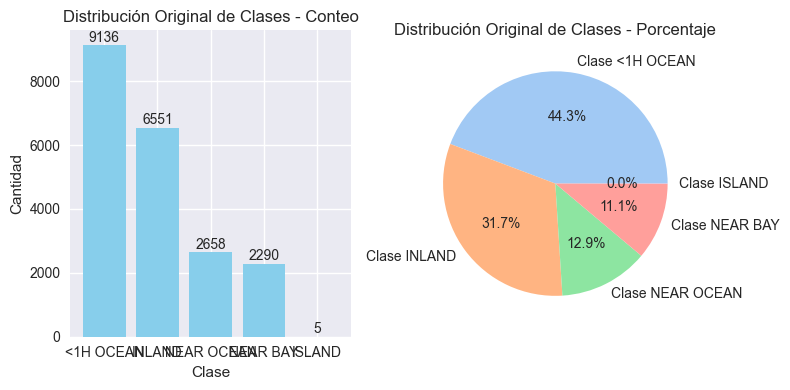

In [29]:

# 4. ANÁLISIS DE LA VARIABLE OBJETIVO
print(f"\n🎯 ANÁLISIS DE LA VARIABLE OBJETIVO:")
target_distribution = data['ocean_proximity'].value_counts()
print(f"   • Clase 0 (Maligno): {target_distribution[0]} ({target_distribution[0]/len(data)*100:.1f}%)")
print(f"   • Clase 1 (Benigno): {target_distribution[1]} ({target_distribution[1]/len(data)*100:.1f}%)")

plot_class_balance(data['ocean_proximity'], "Distribución Original de Clases")



In [30]:
data.columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value', 'ocean_proximity'],
      dtype='object')


📈 ANÁLISIS DE DISTRIBUCIONES:


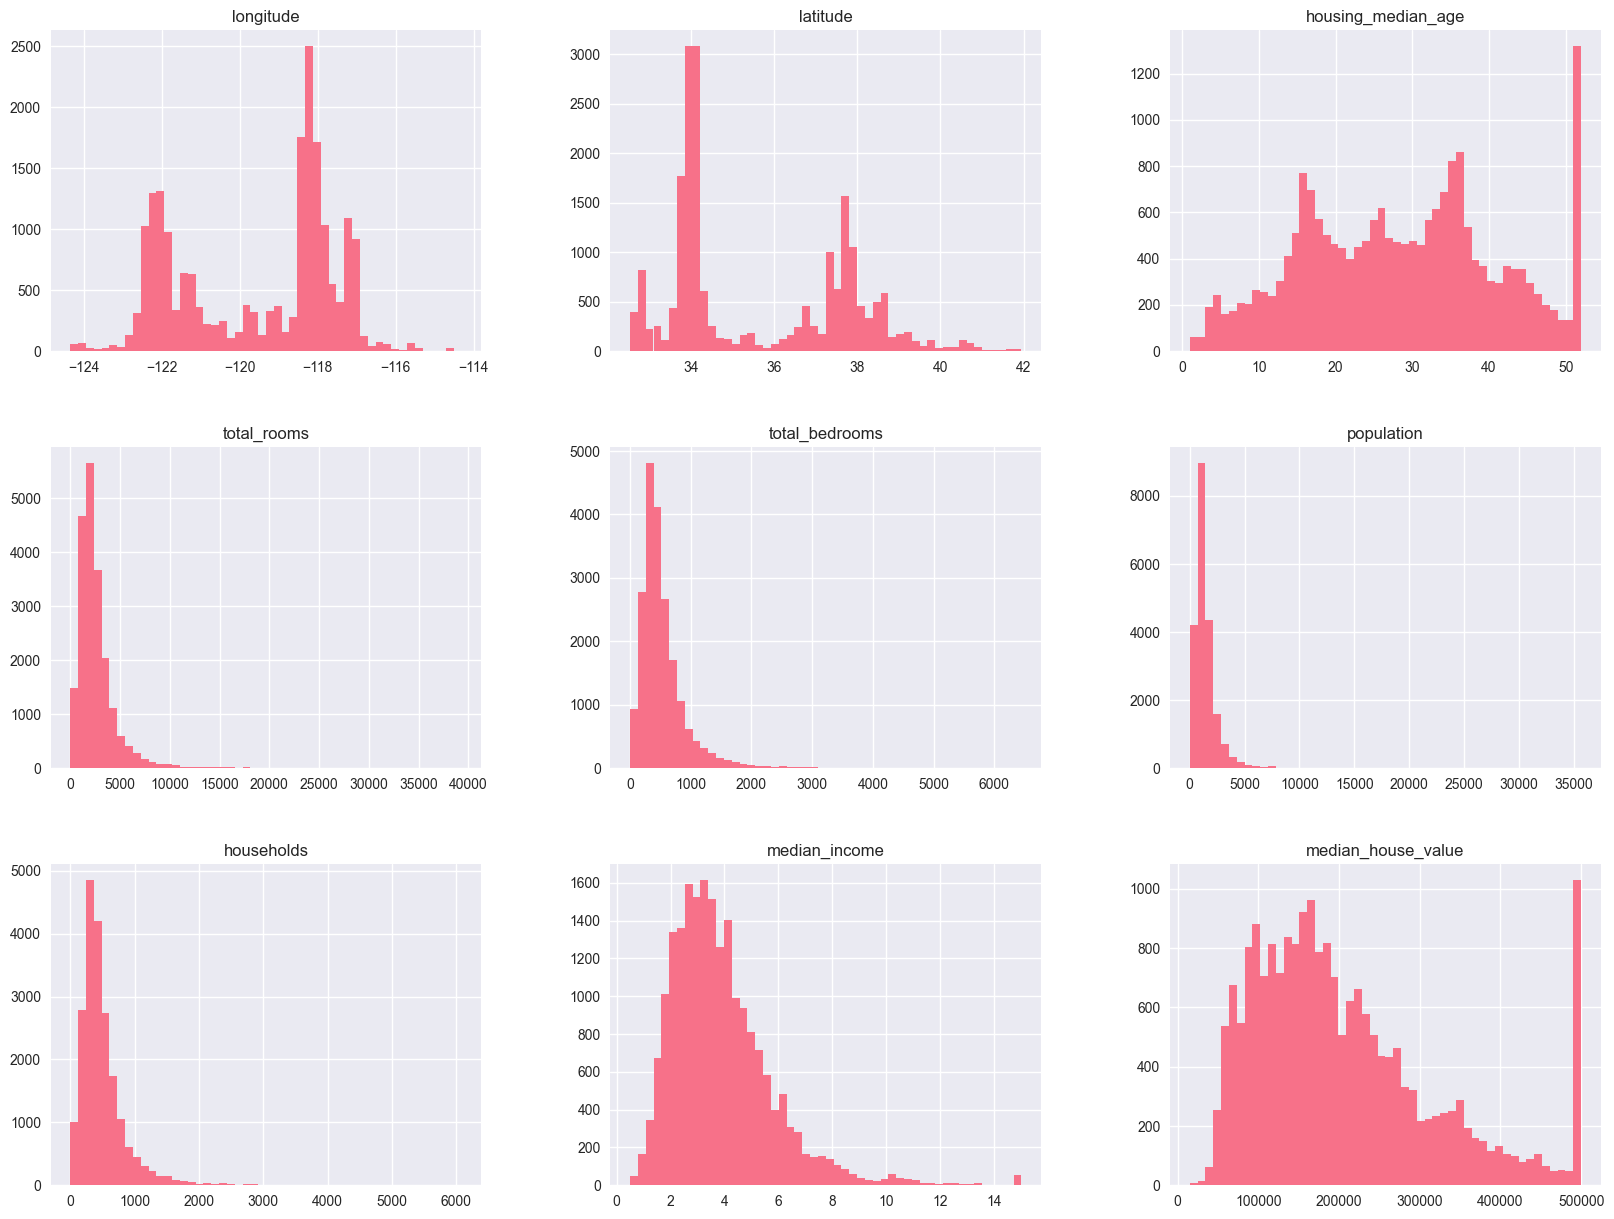

In [31]:
# 5. ANÁLISIS DE DISTRIBUCIONES

print(f"\n📈 ANÁLISIS DE DISTRIBUCIONES:")

data.hist(bins=50, figsize=(20, 15))
plt.show()

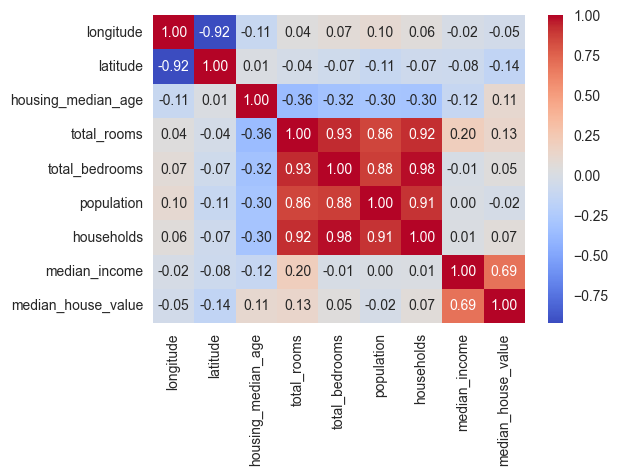

In [32]:
plt.figure(figsize=(6, 4))
sns.heatmap(data.corr(numeric_only=True), annot=True, cmap='coolwarm', fmt=".2f")
plt.show()

In [ ]:
# 7. DETECCIÓN DE OUTLIERS
# ========================

print(f"\n⚠️  ANÁLISIS DE OUTLIERS:")

main_features = ['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value']

# Generar boxplots para las características principales
#plot_outliers(data, main_features[:6],  target_col='median_house_value')

# Detectar outliers usando IQR
def detect_outliers_iqr(df, columns):
    outliers_count = {}
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
        outliers_count[col] = len(outliers)
    return outliers_count

outliers_info = detect_outliers_iqr(data, main_features)
print(f"\n📊 CONTEO DE OUTLIERS POR VARIABLE (método IQR):")
for feature, count in outliers_info.items():
    print(f"   • {feature:<25}: {count:3d} outliers")



⚠️  ANÁLISIS DE OUTLIERS:

📊 CONTEO DE OUTLIERS POR VARIABLE (método IQR):
   • longitude                :   0 outliers
   • latitude                 :   0 outliers
   • housing_median_age       :   0 outliers
   • total_rooms              : 1287 outliers
   • total_bedrooms           : 1271 outliers
   • population               : 1196 outliers
   • households               : 1220 outliers
   • median_income            : 681 outliers
   • median_house_value       : 1071 outliers


In [34]:
promedio_bedrooms = data['total_bedrooms'].mean()
data['total_bedrooms'].fillna(promedio_bedrooms, inplace=True)

In [35]:
data.isnull().sum()

longitude             0
latitude              0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
median_house_value    0
ocean_proximity       0
dtype: int64

In [36]:
# 8. PREPARACIÓN DE DATOS
# =======================

print(f"\n🔧 PREPARACIÓN DE DATOS:")
#### one-hot encoding de 'ocean proximity'
data = pd.get_dummies(data, columns=['ocean_proximity'], drop_first=True)

####
X = data.drop('median_house_value', axis=1)
Y = data['median_house_value']

# División en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=42)

print(f"   • Tamaño conjunto entrenamiento: {X_train.shape}")
print(f"   • Tamaño conjunto prueba: {X_test.shape}")

# Escalado de características
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"   • Características escaladas ✅")




🔧 PREPARACIÓN DE DATOS:
   • Tamaño conjunto entrenamiento: (15480, 12)
   • Tamaño conjunto prueba: (5160, 12)
   • Características escaladas ✅


-----

In [54]:
# 10. ENTRENAMIENTO DE MODELOS
# ============================
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score

print(f"\n🤖 ENTRENAMIENTO DE MODELOS:")
print("=" * 40)

models_results = {}

# 1. Support Vector Machine
print("🔹 Entrenando SVM...")
svm_model = SVR()
svm_model.fit(X_train_scaled, y_train)
svm_pred = svm_model.predict(X_test_scaled)
models_results['SVM'] = {
    'model': svm_model,
    'predictions': svm_pred
}

# 2. Decision Tree
print("🔹 Entrenando Decision Tree...")
dt_model = DecisionTreeRegressor(max_depth=5, random_state=42)
dt_model.fit(X_train_scaled, y_train)
dt_pred = dt_model.predict(X_test_scaled)
models_results['Decision Tree'] = {
    'model': dt_model,
    'predictions': dt_pred
}

# 3. Random Forest
print("🔹 Entrenando Random Forest...")
rf_model = RandomForestRegressor(n_estimators=10, random_state=42)
rf_model.fit(X_train_scaled, y_train)
rf_pred = rf_model.predict(X_test_scaled)
models_results['Random Forest'] = {
    'model': rf_model,
    'predictions': rf_pred
}

# 4. Logistic Regression
print("🔹 Entrenando Logistic Regression...")
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)
lr_pred = lr_model.predict(X_test_scaled)
models_results['Logistic Regression'] = {
    'model': lr_model,
    'predictions': lr_pred
}


🤖 ENTRENAMIENTO DE MODELOS:
🔹 Entrenando SVM...
🔹 Entrenando Decision Tree...
🔹 Entrenando Random Forest...
🔹 Entrenando Logistic Regression...


In [55]:
# 11. EVALUACIÓN DE MODELOS
# =========================

print(f"\n📊 EVALUACIÓN DE MODELOS:")
print("=" * 50)

# Calcular métricas para todos los modelos
evaluation_results = []

for model_name, results in models_results.items():
    metrics = evaluate_model(
        results['model'], 
        X_test_scaled, 
        y_test, 
        results['predictions'], 
        model_name
    )
    evaluation_results.append(metrics)
    
# Crear DataFrame con resultados
results_df = pd.DataFrame(evaluation_results)
results_df = results_df.set_index('Model')
results_df = results_df.round(4)

print(f"\n📋 TABLA COMPARATIVA DE RESULTADOS:")
print("=" * 60)
print(results_df)

# Identificar el mejor modelo por métrica
print(f"\n🏆 MEJORES MODELOS POR MÉTRICA:")
for metric in [ 'MSE','r2', 'MAE']:
    best_model = results_df[metric].idxmax()
    best_score = results_df[metric].max()
    print(f"   • {metric:<10}: {best_model} ({best_score:.4f})")




📊 EVALUACIÓN DE MODELOS:

📋 TABLA COMPARATIVA DE RESULTADOS:
                              MSE      r2         MAE
Model                                                
SVM                  1.384740e+10 -0.0465  87711.2884
Decision Tree        4.978826e+09  0.6237  49810.3195
Random Forest        2.589358e+09  0.8043  33099.8703
Logistic Regression  4.793349e+09  0.6378  50329.9559

🏆 MEJORES MODELOS POR MÉTRICA:
   • MSE       : SVM (13847404855.4558)
   • r2        : Random Forest (0.8043)
   • MAE       : SVM (87711.2884)


In [57]:
# 14. VALIDACIÓN CRUZADA
# ======================
print(f"\n✅ VALIDACIÓN CRUZADA (5-fold):")
cv_results = {}
for model_name, results in models_results.items():
    cv_scores = cross_val_score(results['model'], X_train_scaled, y_train, cv=5)
    cv_results[model_name] = {
        'mean': cv_scores.mean(),
        'std': cv_scores.std(),
        'scores': cv_scores
    }
    
    print(f"   • {model_name:<20}: {cv_scores.mean():.4f} (±{cv_scores.std():.4f})")


✅ VALIDACIÓN CRUZADA (5-fold):
   • SVM                 : -0.0505 (±0.0104)
   • Decision Tree       : 0.6244 (±0.0051)
   • Random Forest       : 0.7958 (±0.0039)
   • Logistic Regression : 0.6449 (±0.0117)
